# Bayesian Assignment of State

In [1]:
import sys
import shutil
sys.path.append("..")
from spc_imports import *
set_up_plt()
import pymc3 as pm
import arviz as az
%run /home/sperez/bin/PYTHON_SCRIPTS/barker.py

/home/sperez/bin/PYTHON_SCRIPTS/spc_imports.py:21: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  plt.rcParams["text.latex.preamble"] = [


In [2]:
raw_data_dir = '../data/raw/'
interim_data_dir = '../data/interim/'
processed_data_dir = '../data/processed/'
external_data_dir = '../data/external/'

## Load and prepare data

In [3]:
%ls ../data/processed/

3FB5_lb/  closed_CS.csv  closed_CS.pkl  diff_CS.pkl  open_CS.csv  open_CS.pkl


In [4]:
df_diff = pd.read_pickle(processed_data_dir+'diff_CS.pkl')

In [5]:
mask = df_diff.dropna(axis=1).columns

In [6]:
df_3fb5 = pd.read_pickle(processed_data_dir+'3FB5_lb/CS_sparta_plus_3FB5_lb.pkl')

In [7]:
df_3fb5 = df_3fb5.loc[:, mask]

In [30]:
df_5vk6 = pd.read_pickle(processed_data_dir+'5VK6_lb/CS_sparta_plus_5VK6_lb.pkl')

In [31]:
df_5vk6 = df_5vk6.loc[:, mask]

In [32]:
df_5vkh = pd.read_pickle(processed_data_dir+'5VKH_lb/CS_sparta_plus_5VKH_lb.pkl')

In [33]:
df_5vkh = df_5vkh.loc[:, mask]

## Study Data

(array([3.59993345e-02, 1.71052103e-02, 3.42884039e-05, 1.13524961e-02,
        8.52760190e-02, 1.33327272e-02, 7.21505394e-02, 6.49551330e-02,
        5.29079175e-02, 3.98599661e-02]),
 array([43.228 , 45.7727, 48.3174, 50.8621, 53.4068, 55.9515, 58.4962,
        61.0409, 63.5856, 66.1303, 68.675 ]),
 <BarContainer object of 10 artists>)

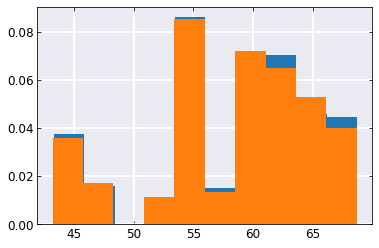

In [34]:
plt.hist(df_3fb5.xs('CA', level='nuclei', axis=1).to_numpy().ravel(), density=True)
plt.hist(df_5vk6.xs('CA', level='nuclei', axis=1).to_numpy().ravel(), density=True)

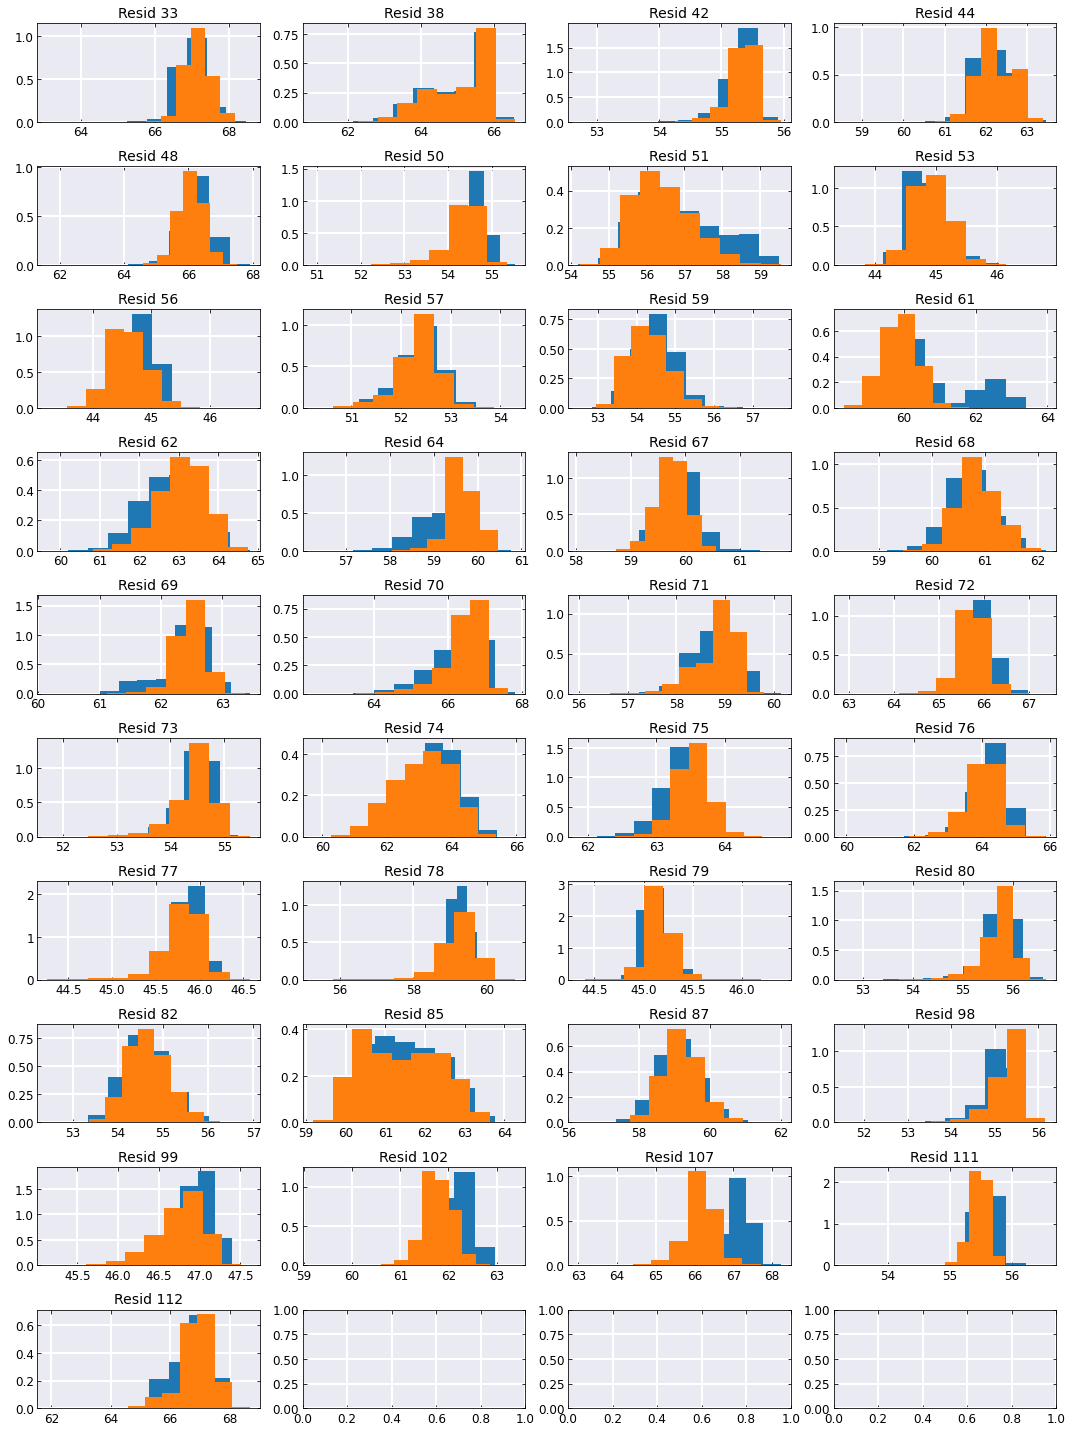

In [35]:
df = df_3fb5.xs('CA', level='nuclei', axis=1)
df2 = df_5vk6.xs('CA', level='nuclei', axis=1)
fig, ax = plt.subplots( df_3fb5.xs('CA', level='nuclei', axis=1).shape[1]//4+1, 4,figsize=(15,20))
ax = ax.flatten()
for i,resid in enumerate(df):
    ax[i].hist(df[resid],
               density=True)
    ax[i].hist(df2[resid],
               density=True)
    ax[i].set_title(f'Resid {resid}')
fig.tight_layout()

## Model Data CA

In [40]:
data_o = df_3fb5[112]['CA']
data_fo = df_3fb5[112]['CA']

In [41]:
with pm.Model() as CA_std_t_model:

    cs_ca_o = pm.Normal('cs_ca_o', sd=2, shape=(1,))
    sd_o = pm.HalfCauchy('sd_o', beta=25, shape=(1,))
    cs_ca_fo = pm.Normal('cs_ca_fo', sd=2, shape=(1,))
    sd_fo = pm.HalfCauchy('sd_fo', beta=25, shape=(1,))
    nu = pm.Exponential('nu', lam=1/29.,shape=(1,) ) + 1
    
    # Define the likelihood.
    like_o = pm.StudentT('like_o', 
                       nu=nu,
                       mu=cs_ca_o, 
                       sd=sd_o, 
                       observed=data_o,
                      shape=(1,))
    like_fo = pm.StudentT('like_fo', 
                       nu=nu,
                       mu=cs_ca_fo, 
                       sd=sd_fo, 
                       observed=data_fo,
                      shape=(1,))
    diff_means = pm.Deterministic('diff_means', cs_ca_o - cs_ca_fo)
    #Check this formula on pooled variance.
    pooled_sd = pm.Deterministic('pooled_sd', 
                                 np.sqrt(np.power(cs_ca_o, 2) + 
                                         np.power(cs_ca_fo, 2) / 2))
    effect_size = pm.Deterministic('effect_size', 
                                   diff_means / pooled_sd)

In [ ]:
%%time
with CA_std_t_model:
    trace = pm.sample(2000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, sd_fo, cs_ca_fo, sd_o, cs_ca_o]
Sampling 4 chains, 0 divergences:  18%|█▊        | 2188/12000 [09:46<3:49:48,  1.41s/draws]

In [ ]:
traces = az.plot_trace(trace)

In [ ]:
traces = az.plot_posterior(trace)

In [21]:
with CA_std_t_model:
    ppc = pm.sample_posterior_predictive(
        trace, samples =1
    )

/home/sperez/data_partition/bin2/anaconda3/envs/lab_env/lib/python3.8/site-packages/pymc3/sampling.py:1246: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(
100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


In [23]:
%%time
idata = az.from_pymc3(trace, posterior_predictive=ppc)
az.plot_ppc(idata)

KeyboardInterrupt: 

In [27]:
az.plot_ppc(trace)

TypeError: `data` argument must have the group "posterior_predictive" for ppcplot